In [68]:
import torch
import torchvision.models as models

In [69]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [70]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/j/.fastai/data/mnist.pkl.gz')

In [71]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [72]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
x_activation_set = x_train.clone()[:24960, :]

train_mean, train_std = x_train.mean(),x_train.std()
print(train_mean)
print(train_std)

tensor(0.1304)
tensor(0.3073)


In [73]:
def normalize(x, mean, std):
    return (x - mean) / std

In [74]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)
x_activation_set = normalize(x_activation_set, train_mean, train_std)

In [75]:
print(f'train mean: {x_train.mean()} std: {x_train.std()}')
print(f'x_valid mean: {x_valid.mean()} std: {x_valid.std()}')
print(f'x_activation_set mean: {x_activation_set.mean()} std: {x_activation_set.std()}')

train mean: -2.319086888746824e-06 std: 1.0
x_valid mean: -0.005850538145750761 std: 0.9924333095550537
x_activation_set mean: 0.003006055485457182 std: 1.0038951635360718


In [76]:
mpl.rcParams['image.cmap'] = 'gray'

In [77]:
img = x_train[0]

In [78]:
img.view(28,28).type()

'torch.FloatTensor'

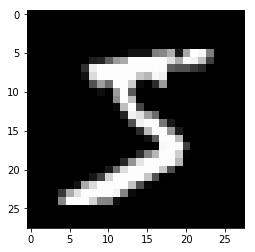

In [79]:
plt.imshow(img.view((28,28)));

In [80]:
print(y_train[0].item())

5


In [102]:
class ELUNet(torch.nn.Module):
    def __init__(self):
        super(ELUNet, self).__init__()
        self.fc1 = torch.nn.Linear(784, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 128)
        self.fc5 = torch.nn.Linear(128, 128)
        self.fc6 = torch.nn.Linear(128, 128)
        self.fc7 = torch.nn.Linear(128, 128)
        self.fc8 = torch.nn.Linear(128, 10)
        self.activation_fn = F.elu

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        x = F.elu(self.fc6(x))
        x = F.elu(self.fc7(x))
        x = self.fc8(x)

        return F.log_softmax(x, dim=1)

class RELUNet(torch.nn.Module):
    def __init__(self):
        super(RELUNet, self).__init__()
        self.fc1 = torch.nn.Linear(784, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 128)
        self.fc5 = torch.nn.Linear(128, 128)
        self.fc6 = torch.nn.Linear(128, 128)
        self.fc7 = torch.nn.Linear(128, 128)
        self.fc8 = torch.nn.Linear(128, 10)
        self.activation_fn = F.relu
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return F.log_softmax(x, dim=1)
    
class LeakyRELUNet(torch.nn.Module):
    def __init__(self):
        super(LeakyRELUNet, self).__init__()
        self.fc1 = torch.nn.Linear(784, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 128)
        self.fc5 = torch.nn.Linear(128, 128)
        self.fc6 = torch.nn.Linear(128, 128)
        self.fc7 = torch.nn.Linear(128, 128)
        self.fc8 = torch.nn.Linear(128, 10)
        self.activation_fn = F.leaky_relu
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc5(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc6(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc7(x), negative_slope=0.1)
        x = self.fc8(x)
        return F.log_softmax(x, dim=1)
    
class BiasedRELUNet(torch.nn.Module):
    @staticmethod
    def biased_relu(x): 
        return x.clamp_min(0.) - 0.5
    
    def __init__(self):
        super(BiasedRELUNet, self).__init__()
        self.fc1 = torch.nn.Linear(784, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 128)
        self.fc5 = torch.nn.Linear(128, 128)
        self.fc6 = torch.nn.Linear(128, 128)
        self.fc7 = torch.nn.Linear(128, 128)
        self.fc8 = torch.nn.Linear(128, 10)
        self.activation_fn = BiasedRELUNet.biased_relu
        
    def forward(self, x):
        x = BiasedRELUNet.biased_relu(self.fc1(x))
        x = BiasedRELUNet.biased_relu(self.fc2(x))
        x = BiasedRELUNet.biased_relu(self.fc3(x))
        x = BiasedRELUNet.biased_relu(self.fc4(x))
        x = BiasedRELUNet.biased_relu(self.fc5(x))
        x = BiasedRELUNet.biased_relu(self.fc6(x))
        x = BiasedRELUNet.biased_relu(self.fc7(x))
        x = self.fc8(x)
        return F.log_softmax(x, dim=1)
    


In [103]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % (len(train_loader) // 4) == 0:
            # pulling mini-batch progress into its own string for easier formatting.
            batch_string = (f'[{batch_idx * len(data)}/{len(train_loader.dataset)}'
                            f'({100. * batch_idx / len(train_loader):.0f}%)]')
                
            print(f'Train Epoch: {epoch:<3} {batch_string:<20} Loss: {loss.item():.6f}')                                                           

In [104]:
def total_loss(model, device, loader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(loader.dataset)
    
    return {'loss'        : loss,
            'num_correct' : correct}

In [105]:
def test(model, device, test_loader, train_loader):
    
    test_results = total_loss(model, device, test_loader)
    train_results = total_loss(model, device, train_loader)
    
    test_loss = test_results['loss']
    test_correct = test_results['num_correct']

    train_loss = train_results['loss']
    train_correct = train_results['num_correct']
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {test_correct}/{len(test_loader.dataset)} ({100. * test_correct / len(test_loader.dataset):.0f}%)\n')
    print(f'Train set: Average loss: {train_loss:.4f}, '
      f'Accuracy: {train_correct}/{len(train_loader.dataset)} ({100. * train_correct / len(train_loader.dataset):.0f}%)\n')
    
    return {'test_loss'  : test_loss, 
            'train_loss' : train_loss}


In [106]:
def mean_activation(model, device, activation_test_loader):
    model.eval()
    mean_activations = 0.0
    norm_factor = 1. / 8.
    activations = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        
        return hook
    
    with torch.no_grad():
        # Add hooks for computing average activation.
        fc1_handle = model.fc1.register_forward_hook(get_activation('fc1'))
        fc2_handle = model.fc2.register_forward_hook(get_activation('fc2'))
        fc3_handle = model.fc3.register_forward_hook(get_activation('fc3'))
        fc4_handle = model.fc4.register_forward_hook(get_activation('fc4'))
        fc5_handle = model.fc5.register_forward_hook(get_activation('fc5'))
        fc6_handle = model.fc6.register_forward_hook(get_activation('fc6'))
        fc7_handle = model.fc7.register_forward_hook(get_activation('fc7'))
        fc8_handle = model.fc8.register_forward_hook(get_activation('fc8'))

        for x in activation_test_loader:
            data = x[0].to(device)

            output = model(data)

            for element in activations:    
                #print(f"elementShape: {activations[element].shape}")
                activation_fn = model.activation_fn

                if activation_fn == F.leaky_relu:
                    mean_activations += activation_fn(activations[element], negative_slope=0.1).mean().item() * norm_factor
                else:
                    mean_activations += activation_fn(activations[element]).mean().item() * norm_factor

        mean_activations /= len(activation_test_loader)

        fc1_handle.remove()
        fc2_handle.remove()
        fc3_handle.remove()
        fc4_handle.remove()
        fc5_handle.remove()
        fc6_handle.remove()
        fc7_handle.remove()
        fc8_handle.remove()

    print(f"mean activation: {mean_activations:.4f}")
        
    return mean_activations

In [107]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [108]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_valid, y_valid)
activation_test_dataset = torch.utils.data.TensorDataset(x_activation_set)

In [109]:
98 * 256

25088

In [134]:
t_model = None
t_model = RELUNet()

for params in t_model.parameters():
    if params.data.dim() == 2:
        print(f'Before - mean: {params.mean()}, std: {params.std()}')


t_model = t_model.apply(init_weights)
print('-----------------------------------------------------------------------------')

total_std = 0
for params in t_model.parameters():
    if params.data.dim() == 2:
        total_std += params.std()
        print(f'After - mean: {params.mean()}, std: {params.std()}')
#         print(params)

print(f'total stdev = {total_std}')

Before - mean: 4.421262929099612e-05, std: 0.020606495440006256
Before - mean: -0.00017039463273249567, std: 0.05113699287176132
Before - mean: -0.0006515454151667655, std: 0.05086797848343849
Before - mean: 0.0003819070116151124, std: 0.051259368658065796
Before - mean: -0.0003702500252984464, std: 0.05098085105419159
Before - mean: -0.00011002244718838483, std: 0.05091703683137894
Before - mean: -0.00017100712284445763, std: 0.05093710124492645
Before - mean: -4.990950765204616e-05, std: 0.0516427718102932
-----------------------------------------------------------------------------
After - mean: -3.820666461251676e-05, std: 0.050436556339263916
After - mean: -0.0017552259378135204, std: 0.12501567602157593
After - mean: 0.00023908735602162778, std: 0.12458109855651855
After - mean: 0.0003903487231582403, std: 0.12537115812301636
After - mean: -0.0005305547965690494, std: 0.12493725121021271
After - mean: 0.0015680694486945868, std: 0.12606129050254822
After - mean: -0.00212572165764

In [ ]:
test_results = []

for test_idx in range(0, 5):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,**kwargs)

    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=64, 
                                              shuffle=True, 
                                              **kwargs)

    activation_test_loader = torch.utils.data.DataLoader(activation_test_dataset, 
                                                         batch_size=256, 
                                                         shuffle=False, 
                                                         **kwargs)
    
    models = [BiasedRELUNet(), ELUNet(), RELUNet(), LeakyRELUNet()]
    result = []

    for idx, model in enumerate(models):
        model = model.to(device)
        model.apply(init_weights)
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

        result.append({'avg_activations'       : [],
                        'losses'                : []})

        for epoch in range(1, 125 + 1):
            train(model, device, train_loader, optimizer, epoch)

            avg_activation = mean_activation(model, device, activation_test_loader)
            losses = test(model, device, test_loader, train_loader)

            result[idx]['avg_activations'].append(avg_activation)
            result[idx]['losses'].append(losses)
     
    test_results.append(result)

In [273]:
results_mat = np.array([results[0]['avg_activations'], 
                       results2[0]['avg_activations'], 
                       results3[0]['avg_activations'],
                       results4[0]['avg_activations'],
                       results5[0]['avg_activations']])
print(results_mat)
print(np.median(results_mat, axis=0))
print(results_mat.std(0))

[[0.318762 0.338193 0.362846 0.372901 ... 1.16976  1.170357 1.172812 1.173526]
 [0.390424 0.38889  0.389447 0.402185 ... 0.999304 1.000543 1.00233  1.003611]
 [0.140783 0.176708 0.179971 0.201974 ... 0.841593 0.843237 0.844152 0.845339]
 [0.558622 0.553893 0.577356 0.609098 ... 1.289962 1.292576 1.293001 1.29493 ]
 [0.327348 0.307543 0.304913 0.330756 ... 0.94074  0.94186  0.944009 0.945005]]
[0.327348 0.338193 0.362846 0.372901 ... 0.999304 1.000543 1.00233  1.003611]
[0.134446 0.122483 0.129245 0.131977 ... 0.161153 0.161381 0.161248 0.161419]


In [116]:
results_matrix = np.array(test_results)

In [118]:
results_matrix.shape

(5, 4)

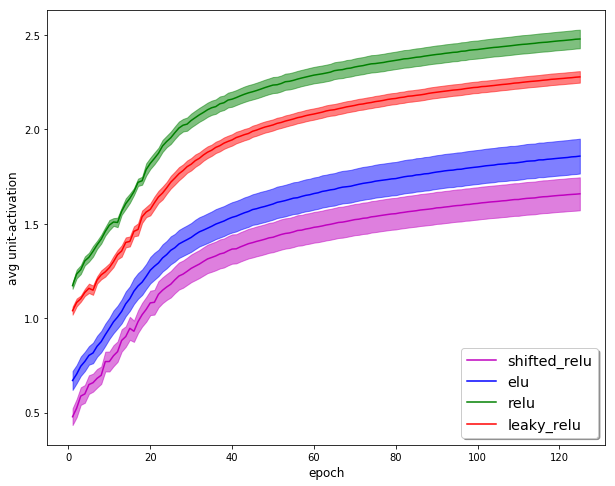

In [132]:
colors = ['m', 'b', 'g', 'r']
fig, ax = plt.subplots(figsize=(10, 8))
labels = ['shifted_relu', 'elu', 'relu', 'leaky_relu']

for i, label in enumerate(labels):
    activations_matrix = np.array([test_results[0][i]['avg_activations'], 
                            test_results[1][i]['avg_activations'], 
                            test_results[2][i]['avg_activations'],
                            test_results[3][i]['avg_activations'],
                            test_results[4][i]['avg_activations']])
    
    act_std = activations_matrix.std(0)
    
    y = np.median(activations_matrix, axis=0)
    x = np.array(range(1, len(y) + 1))
    
    ax.plot(x, y, colors[i]+'-', label=label)
    plt.fill_between(x, y - act_std / 2, y + act_std / 2, alpha=0.5, color=colors[i])
    
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.ylabel('avg unit-activation', fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.show()


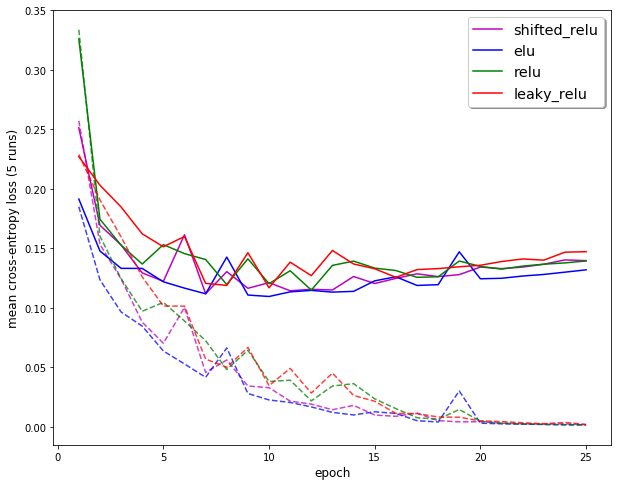

In [135]:
test_colors = ['m', 'b', 'g', 'r']
train_colors = ['m', 'b', 'g', 'r']
fig, ax = plt.subplots(figsize=(10, 8))
labels = ['shifted_relu', 'elu', 'relu', 'leaky_relu']

for i, label in enumerate(labels):
    
    test_losses = np.array([list(map(lambda x: x['test_loss'],test_results[0][i]['losses'])),
                           list(map(lambda x: x['test_loss'], test_results[1][i]['losses'])),
                           list(map(lambda x: x['test_loss'], test_results[2][i]['losses'])),
                           list(map(lambda x: x['test_loss'], test_results[3][i]['losses'])),
                           list(map(lambda x: x['test_loss'], test_results[4][i]['losses']))])
    
    train_losses = np.array([list(map(lambda x: x['train_loss'],test_results[0][i]['losses'])),
                           list(map(lambda x: x['train_loss'], test_results[1][i]['losses'])),
                           list(map(lambda x: x['train_loss'], test_results[2][i]['losses'])),
                           list(map(lambda x: x['train_loss'], test_results[3][i]['losses'])),
                           list(map(lambda x: x['train_loss'], test_results[4][i]['losses']))])
    
    train_stdev = train_losses.std(0)
    
    y_test = np.mean(test_losses, axis=0)
    y_train = np.mean(train_losses, axis=0)
    
    x = np.array(range(1, len(y_test) + 1))

    ax.plot(x[:25], y_test[:25], test_colors[i] + '-', label=label)
    ax.plot(x[:25], y_train[:25], train_colors[i] + '--', alpha=0.75)
    
#     plt.fill_between(x[:25], y_train[:25] - train_stdev[:25] / 2, y_train[:25] + train_stdev[:25] / 2, color=colors[i], alpha=.5)
    
legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
plt.ylabel('mean cross-entropy loss (5 runs)', fontsize='large')
plt.xlabel('epoch', fontsize='large')

plt.show()


In [ ]:
print(activation['fc1'])

In [193]:
a = F.elu(activation['fc1']);a

tensor([[ 0.8321, -0.4655, -0.1547,  ...,  1.0117, -0.0656,  0.0241],
        [ 0.1219, -0.7453,  0.3095,  ...,  2.8145, -0.5336,  0.4464],
        [ 0.3887, -0.4203, -0.1030,  ...,  3.3170,  0.3581, -0.2016],
        ...,
        [ 1.6115, -0.4921, -0.7329,  ...,  3.9743,  0.2590,  1.5162],
        [ 2.7953, -0.9866,  0.2274,  ...,  1.5615,  0.9475,  1.1705],
        [ 1.8262,  0.7822, -0.1567,  ...,  3.0519,  0.4510, -0.0679]],
       device='cuda:0')

In [195]:
a.mean().item()

0.20978084206581116

In [199]:
for element in activation:
    print(activation[element])

tensor([[ 0.8321, -0.6264, -0.1681,  ...,  1.0117, -0.0678,  0.0241],
        [ 0.1219, -1.3675,  0.3095,  ...,  2.8145, -0.7628,  0.4464],
        [ 0.3887, -0.5452, -0.1087,  ...,  3.3170,  0.3581, -0.2252],
        ...,
        [ 1.6115, -0.6775, -1.3202,  ...,  3.9743,  0.2590,  1.5162],
        [ 2.7953, -4.3133,  0.2274,  ...,  1.5615,  0.9475,  1.1705],
        [ 1.8262,  0.7822, -0.1704,  ...,  3.0519,  0.4510, -0.0703]],
       device='cuda:0')
tensor([[-0.7385, -1.2345, -1.3308,  ...,  0.2038, -2.4119,  2.0972],
        [-1.1172, -0.9805, -0.4449,  ...,  0.0466, -3.3445,  1.9234],
        [-0.0964, -1.8834, -1.2713,  ..., -1.6756, -0.2612,  0.4088],
        ...,
        [-0.2986, -1.9977, -0.5298,  ..., -0.4228, -2.8474,  0.8286],
        [-0.9477, -1.2709, -2.7579,  ..., -2.5604, -3.3027,  0.3923],
        [ 2.0014, -3.0230, -1.7367,  ...,  0.7687, -1.3486,  1.6613]],
       device='cuda:0')
tensor([[-2.5396, -1.2503,  1.5203,  ..., -0.6194,  0.3067, -0.8677],
        [-2.81

In [201]:
for element in activation:
    print(element)

fc1
fc2
fc3
fc4
fc5
fc6
fc7
fc8


In [202]:
print(len(activation))

8


In [216]:
len(x_activation_set)

1024